In [1]:
import cudf
import cuml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import umap.plot
import bokeh.plotting as bpl
from cuml.manifold.umap import UMAP as clUMAP
from cuml.cluster import KMeans as cuKM
from cuml.decomposition import PCA as cuPCA
%matplotlib inline

In [2]:
df = pd.read_csv('/home/lima/Projects/simulation/SingleSample/Samples/allCounts/countsMatrixWithCutOffZero.csv')

In [3]:
df = df.rename(columns = {"Unnamed: 0": "GeneID"})
df.iloc[ : , 1 : ] = np.log2(df.iloc[ : , 1 : ] + 1)

In [4]:
cdf = cudf.from_pandas(df)

In [5]:
km_cdf = cdf.drop(['GeneID'])

In [6]:
pca = cuPCA(n_components = 2, svd_solver = 'full', whiten = False, random_state = 42)

In [7]:
%%time
output_pca = pca.fit_transform(km_cdf)

CPU times: user 419 ms, sys: 83.5 ms, total: 503 ms
Wall time: 502 ms


In [8]:
%%time
kmeans = cuKM(init = 'k-means||', n_clusters = 26, random_state = 42)
kmeans.fit(output_pca)

CPU times: user 327 ms, sys: 0 ns, total: 327 ms
Wall time: 326 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f3284ab6f70>, n_clusters=26, max_iter=300, tol=0.0001, verbose=0, random_state=42, init='k-means||', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [9]:
y_kmeans = kmeans.predict(output_pca)

In [10]:
output_pca['Predict'] = y_kmeans

In [11]:
pd_pca = output_pca.to_pandas().values

In [12]:
pd_pca = pd.DataFrame(pd_pca, columns = ['PC1', 'PC2', 'Predict'])

[]

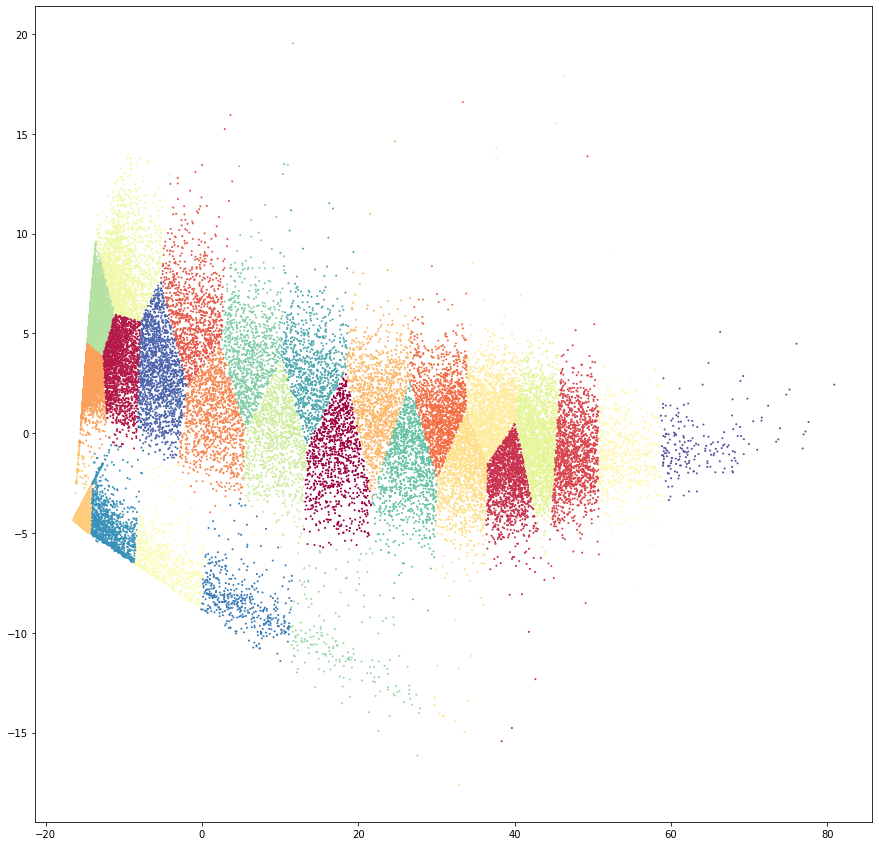

In [13]:
plt.figure(figsize = (15, 15))
plt.scatter(pd_pca.PC1, pd_pca.PC2, c = pd_pca.Predict, s = 1, cmap = 'Spectral')
plt.plot()

In [14]:
%%time
kmeans = cuKM(init = 'k-means||', n_clusters = 4, random_state = 42)
kmeans.fit(output_pca)

CPU times: user 21.4 ms, sys: 3.07 ms, total: 24.5 ms
Wall time: 23.3 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f3284ab6ed0>, n_clusters=4, max_iter=300, tol=0.0001, verbose=0, random_state=42, init='k-means||', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [15]:
y_kmeans = kmeans.predict(output_pca)

In [16]:
output_pca['Predict'] = y_kmeans

In [17]:
pd_pca = output_pca.to_pandas().values

In [18]:
pd_pca = pd.DataFrame(pd_pca, columns = ['PC1', 'PC2', 'Predict'])

[]

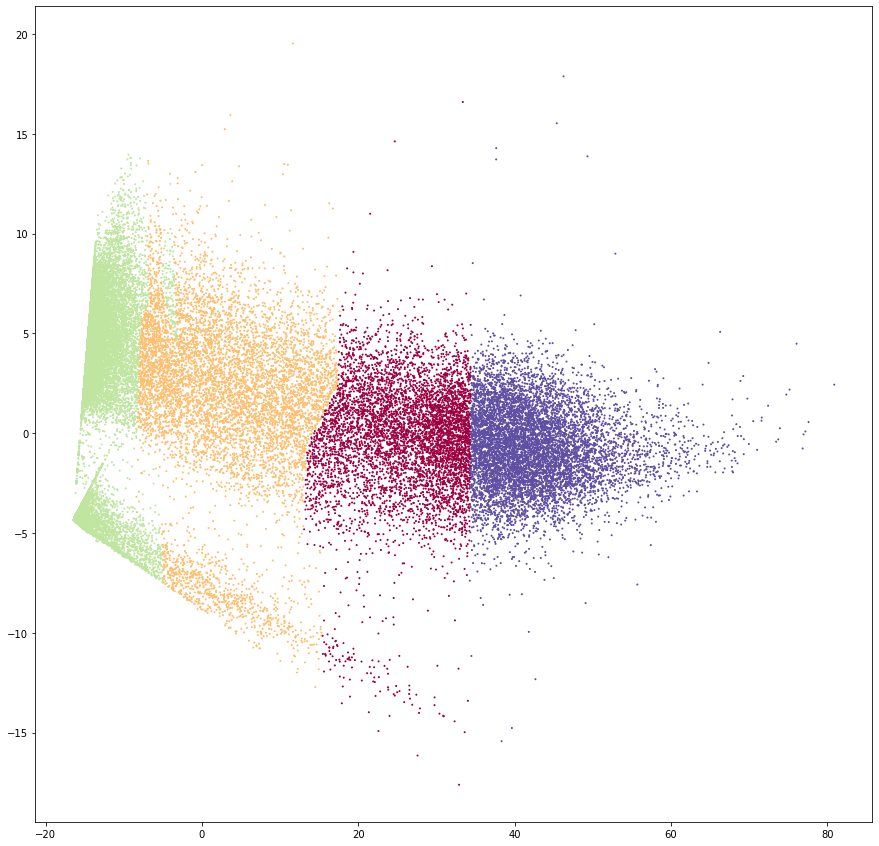

In [19]:
plt.figure(figsize = (15, 15))
plt.scatter(pd_pca.PC1, pd_pca.PC2, c = pd_pca.Predict, s = 1, cmap = 'Spectral')
plt.plot()

In [20]:
%%time
kmeans = cuKM(init = 'k-means||', n_clusters = 2, random_state = 42)
kmeans.fit(output_pca)

CPU times: user 24.1 ms, sys: 14.8 ms, total: 38.9 ms
Wall time: 38.8 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f32844b8c10>, n_clusters=2, max_iter=300, tol=0.0001, verbose=0, random_state=42, init='k-means||', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [21]:
y_kmeans = kmeans.predict(output_pca)

In [22]:
output_pca['Predict'] = y_kmeans

In [23]:
pd_pca = output_pca.to_pandas().values

In [24]:
pd_pca = pd.DataFrame(pd_pca, columns = ['PC1', 'PC2', 'Predict'])

[]

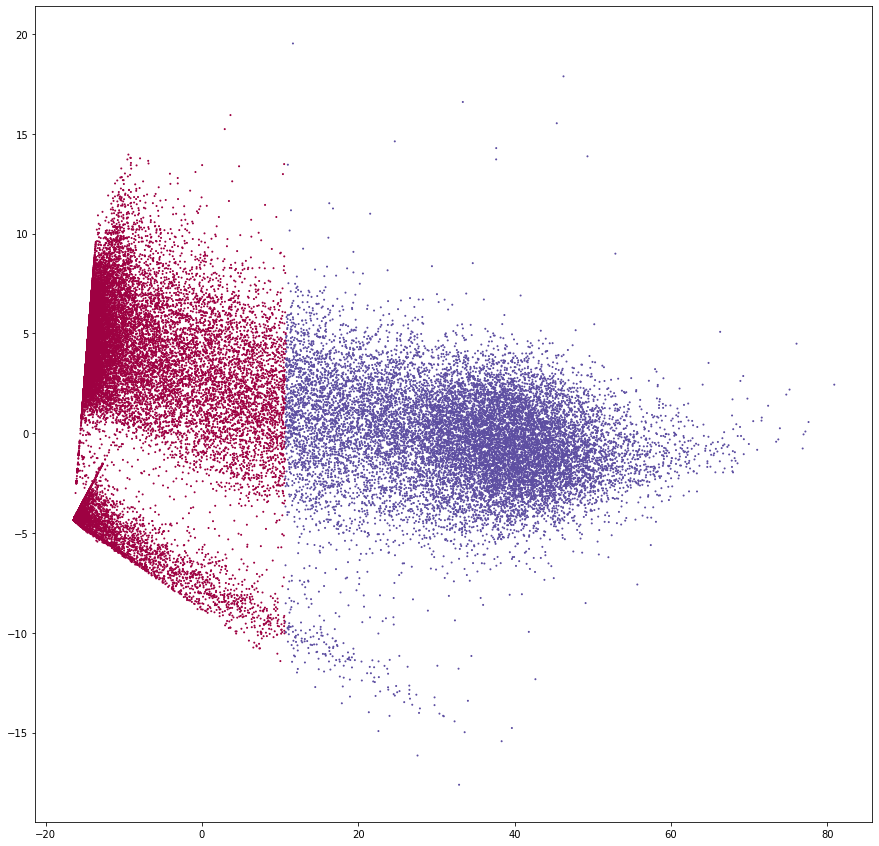

In [25]:
plt.figure(figsize = (15, 15))
plt.scatter(pd_pca.PC1, pd_pca.PC2, c = pd_pca.Predict, s = 1, cmap = 'Spectral')
plt.plot()